In [76]:
import os
import glob

DIR = "regions"
dig_classes = 10

f_names = glob.glob(os.path.join(DIR, "*.png")) 

print(f_names.__len__())

5998


In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [78]:
print(f_names[0])

regions/1602138135_d3603a.png


In [79]:
# generating number labels
def get_label(f_name):
    return f_name.split("/")[1].split("_")[0]
labels = list(map(get_label, f_names))
print(labels[0])

1602138135


In [80]:
# checking number lengths
digit_lengths = set(map(len, labels))
print(len(digit_lengths), digit_lengths)

3 {8, 9, 10}


In [81]:
# digit map marking every digit in image_n, digit_pos tuple
digit_map = {i:[] for i in range(dig_classes)}

for i, digits in enumerate(labels):
    for j, dig in enumerate(digits):
        digit_map[j].append((i, j))

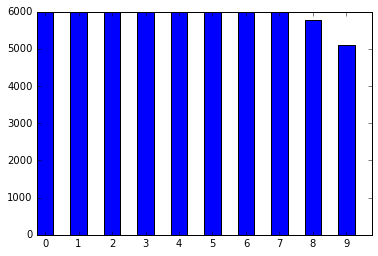

In [82]:
# creating digit frequencies to draw histogram to investigate class balance
digit_hist = [(i, len(digit_map[i])) for i in range(dig_classes)]
digits, d_freq = zip(*digit_hist)

fig, ax = plt.subplots()
bar_width = 0.5
index = np.arange(dig_classes)
ax.bar(index, d_freq, bar_width, label="Digits")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
plt.show()

In [83]:
import cv2
images = list(map(cv2.imread, f_names)) # BGR format
images_gray = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

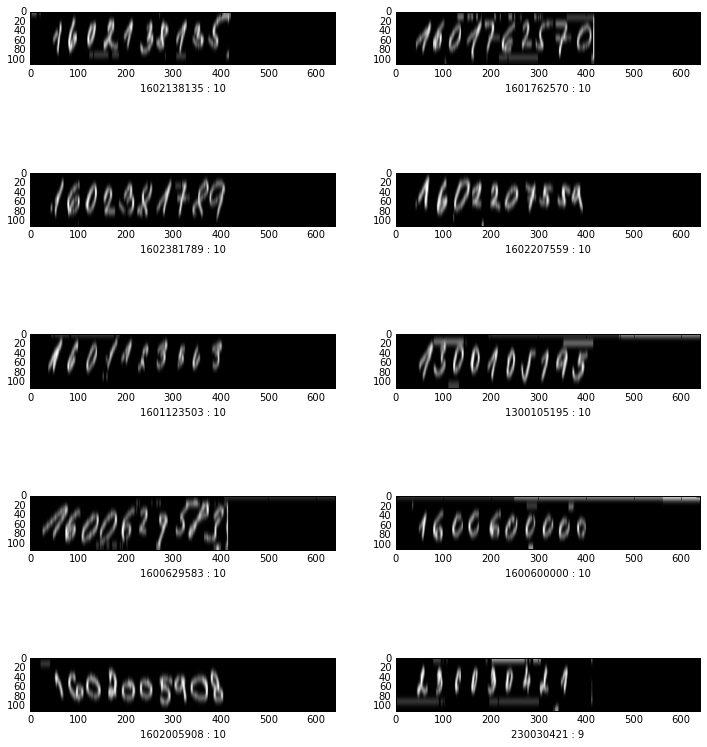

In [84]:
def gen_subplot_group(n, cols=2, size=1.0, colsize=1.0, yield_group=1):
    """generates index, axes tuple from figure subplots
        generates `yield_group` axes at once
    """
    rows = n//cols
    row_size_mul = 1.4 * size
    col_size_mul = 6 * colsize
    fig = plt.figure(figsize=(int(cols*col_size_mul), int(rows*row_size_mul)))
    group = []
    for i in range(1, rows*cols+1):
        ax = fig.add_subplot(rows, cols, i)
        group.append(ax)
        if len(group) == yield_group:
            yield ((i//yield_group)-1, group)
            group = []

def draw_images(images, labels, gray=False, to_rgb=True, n=10, gauss_blur_kernel=(3, 3)):
    """
    draws `n` images in graymap/converting to RGB from BGR
    gray and to_rgb are mutually exclusive
    
    `gauss_blur_kernel`: (x, y) use Gaussian blur with this kernel size to remove noise 
        with a Gaussian filter. x & y must be odd.
    """
    for i, axes in gen_subplot_group(n, size=2.0):
        ax = axes[0]
        args = [cv2.GaussianBlur(images[i], gauss_blur_kernel, 0), ] # cv2.GaussianBlur(gray,(3,3), 0)
        args = [cv2.threshold(images[i], 200,255,cv2.THRESH_BINARY_INV)[1], ]
        args = [cv2.GaussianBlur(args[0], gauss_blur_kernel, 0), ]
        args[0] = cv2.resize(args[0], (0, 0), fx=2.0, fy=3.0)
        # check inverting image instead of thesh
        kwargs = {}
        if gray: 
            kwargs["cmap"] = "gray"
        elif to_rgb: 
            args[0] = args[0][:, :, ::-1]
        plt.imshow(*args, **kwargs)
        ax.set_xlabel(labels[i] + " : {}".format(len(labels[i])))
        
        
draw_images(images_gray, labels, gray=True, gauss_blur_kernel=(1, 11))

1602138135
1601762570
1602381789
1602207559
1601123503
1300105195
1600629583
1600600000
1602005908
230030421


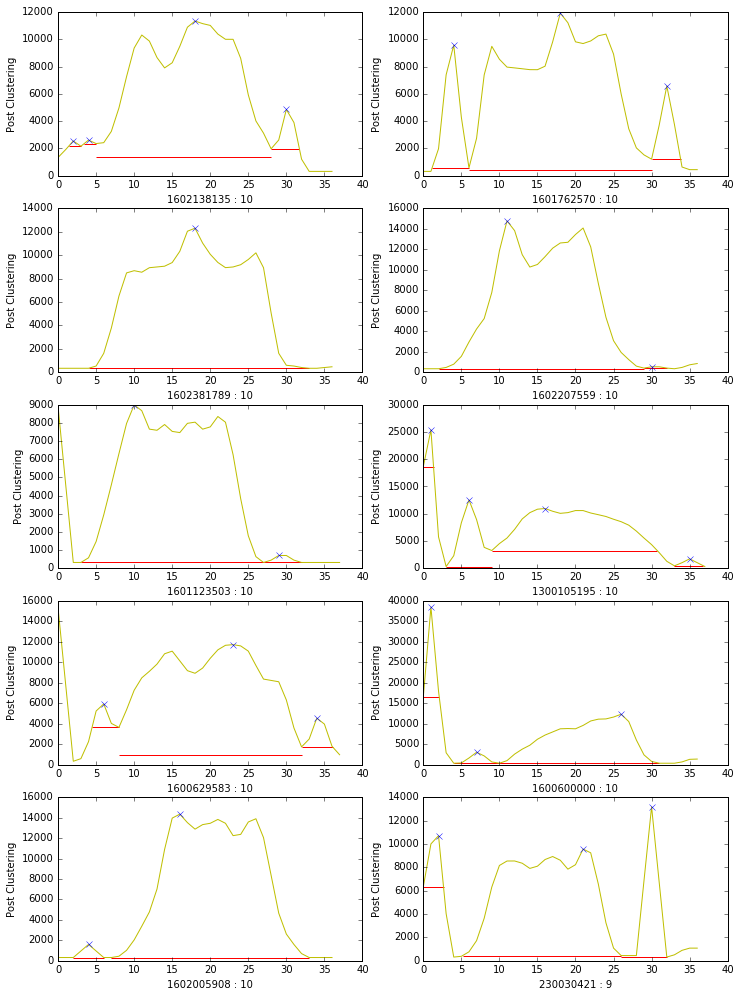

In [85]:
from scipy.signal import find_peaks, peak_widths, peak_prominences

def cluster_peaks(x, peaks, peak_prom, width_results, max_width_only=False, threshold=0.5):
    """
    unsupervised clustering of peaks
    merges overlapping peaks after applying prominence threshold
    suppresses local minima in signals

    Args:
        `peaks`: peak indices
        `peak_prom`: peak prominences
        `width_results`: peak width results from scipy.signal.peak_widths
        `max_width_only`: if True, returns only maximum width peak after merging

    Creates `peak_stats`: format: [(p_i, p_prom, w, w_h, st, en), ...]
            tuples of (peak_indices, peak_prominences, peak_width, peak_base_height, start, end

    Returns:
        `peak_stats` in separated format: 
            peak_indices, peak_prominences, peak_width, peak_base_height, start, end

    # TODO: optimize by using merged candidate bool map instead of delete from array
            optimize by changing presort according to start, end to find candidates faster
            optimize for noise filtering: filter peaks that are on edges
            optimize data contract binding: remove unneccary use of zip/map and improve data interoperability
    """
    # changing zipped tupples to list for mutability
    peak_stats = list(map(lambda x: list(x), zip(peaks, peak_prom, *width_results)))
    peak_stats.sort(key=lambda x: x[2], reverse=True) # sort peaks by width
    # peaks should be merged with a parent peak of minimum width, hence sorting is required
    # TODO: recheck efficient deletes creating dict array for O1 deletes
    # peak_dict = {i: peak_stat for i, peak_stat in enumerate(peak_stats)}
    count = len(peak_stats)

    def remove_cand_from_cur(cur, cand):
        """Removes overlapping but unmergable candidate peak from current peak"""
        # change current's width and remove candidate width from it
        # Note: changes to cur will be reflected in peak_stats list as cur is a list object
        if cand[0] > cur[0]:
            # candidate is right of cur, change cur_end to cand_start
            cur[-1] = cand[-2]
        else:
            # candidate is left of cur, change cur_start to cand_end
            cur[-2] = cand[-1]
        cur[2] = cur[-1] - cur[-2]

    for i in reversed(range(len(peak_stats)-1)):
        cur = peak_stats[i]
        merged = []
        # iterating through every peak with width less than that of current peak
        # to find merge candidates
        for j in range(i+1, count):
            cand = peak_stats[j]
            # if start and end of candidate peak lies between start and end of current peak
            # try to merge with current after applying threshold


            if cand[-2] >= cur[-2] and cand[-1] <= cur[-1]:
                # if prominence height of candidate is less than threshold fraction
                # of that of current peak -> merge
                if cand[1] < threshold * cur[1]:
                    # if base height of candidate is atleast threshold fraction of cur peak height
                    # implies candidate peak is close to current peak in height
                    if cand[3] >= x[cur[0]] * (1 - threshold):
                        merged.append(j)
                    else:
                        # can't merge candidate peak, removing it's edges from current peak
                        remove_cand_from_cur(cur, cand)
                else:
                    # peaks can't be merged, calculate true width of current
                    t_cur_w = cur[2] - cand[2]
                    # find if current peak is left or right of candidate
                    if cur[0] > cand[0]:
                        # current is right of cand, true width is cur_end - cand_end
                        t_cur_w = cur[-1] - cand[-1]
                    else:
                        # current is left of cand, true width is cand_start - cur_start
                        t_cur_w = cand[-2] - cur[-2]
                    # if true width of current is less than candidate, merge current into candidate
                    # while trimming any non-overlapping edges -> just delete current instead
                    if t_cur_w < cand[2]:
                        pass
                        # TODO: merge current? remove false peak: narrow but peakier? 
                        # merged.append(i)
                    remove_cand_from_cur(cur, cand)


        # performing merge: just removing merged candidates from peak_dict
        # sorting merge list to delete largest index first
        merged.sort(reverse=True)
        for j in merged:
            del peak_stats[j]
            count -= 1
            
    if max_width_only:
        peak_stats = [max(peak_stats, key=lambda x: x[2]), ]

    return list(zip(*peak_stats))
        
def process_projection_peaks(x, ax=None, ax_plot_diff=None, *args, **kwargs):
    """Finds peaks in projection, clusters them according to prominence and returns
        can also plot signal (pre/post clustering) as per axes provided
    Args:
        `x`: 1D projection of signal
        `ax`: plt axis to visualize peaks post clustering
        `ax_plot_diff`: plt axis to visualize peaks pre clustering
    Returns:
        `res`: [peaks, peak_widths_l, peak_base_heights, starts, ends]
    """
    def plot_peaks(ax, peaks, width_res):
        ax.plot(x, color="y")
        ax.plot(peaks, x[peaks], "x")
        ax.hlines(*width_res[1:], color="red")
        
        
    peaks, _ = find_peaks(x)
    peak_prom = peak_prominences(x, peaks)[0]
    width_res = peak_widths(x, peaks, rel_height=1)
    # format: p_i, p_prom, w, w_h, st, en
    
    if ax_plot_diff:
        plot_peaks(ax_plot_diff, peaks, width_res)
        ax_plot_diff.set_ylabel("Pre Clustering")
    
    peaks, peak_prom, peak_widths_l, peak_base_heights, starts, ends = cluster_peaks(x, peaks, peak_prom, width_res, *args, **kwargs)
    res = [peaks, peak_widths_l, peak_base_heights, starts, ends]
    if ax:
        peaks = np.array(peaks)
        plot_peaks(ax, peaks, list(res[1:]))
        ax.set_ylabel("Post Clustering")
        
    return res

def plot_projections(images_gray, labels=None, n=10, axis=1, plot_diff=False, *args, **kwargs):
    """plots vertical/horizontal projections (sum of pixels) for grayscale images
        after performing peak clustering 
        # TODO: documentation
    """    
    if plot_diff:
        n = 2*n

    for i, axes in gen_subplot_group(n, size=2.5, yield_group=(1+plot_diff)):
        # TODO: streamline experimental image pre processing pipeline
        ret, thresh = cv2.threshold(images_gray[i], 200, 255,cv2.THRESH_BINARY_INV)
        blur_img = cv2.GaussianBlur(thresh, (5, 3), 0)
        
        # TODO: deprecated. 
        # scaled_image = (images_gray[i]) / 255
        
        # scaling image for better visualizations
        scaled_image = blur_img - 255
        project = np.sum(scaled_image, axis=axis)
        
        process_projection_peaks(project, *reversed(axes), *args, **kwargs)
            
        print(labels[i])
        
        for ax in axes:
            ax.set_xlabel(labels[i] + " : {}".format(len(labels[i])))
            
plot_projections(images_gray, labels, axis=1)

1602138135
1601762570
1602381789
1602207559
1601123503
1300105195
1600629583
1600600000
1602005908
230030421


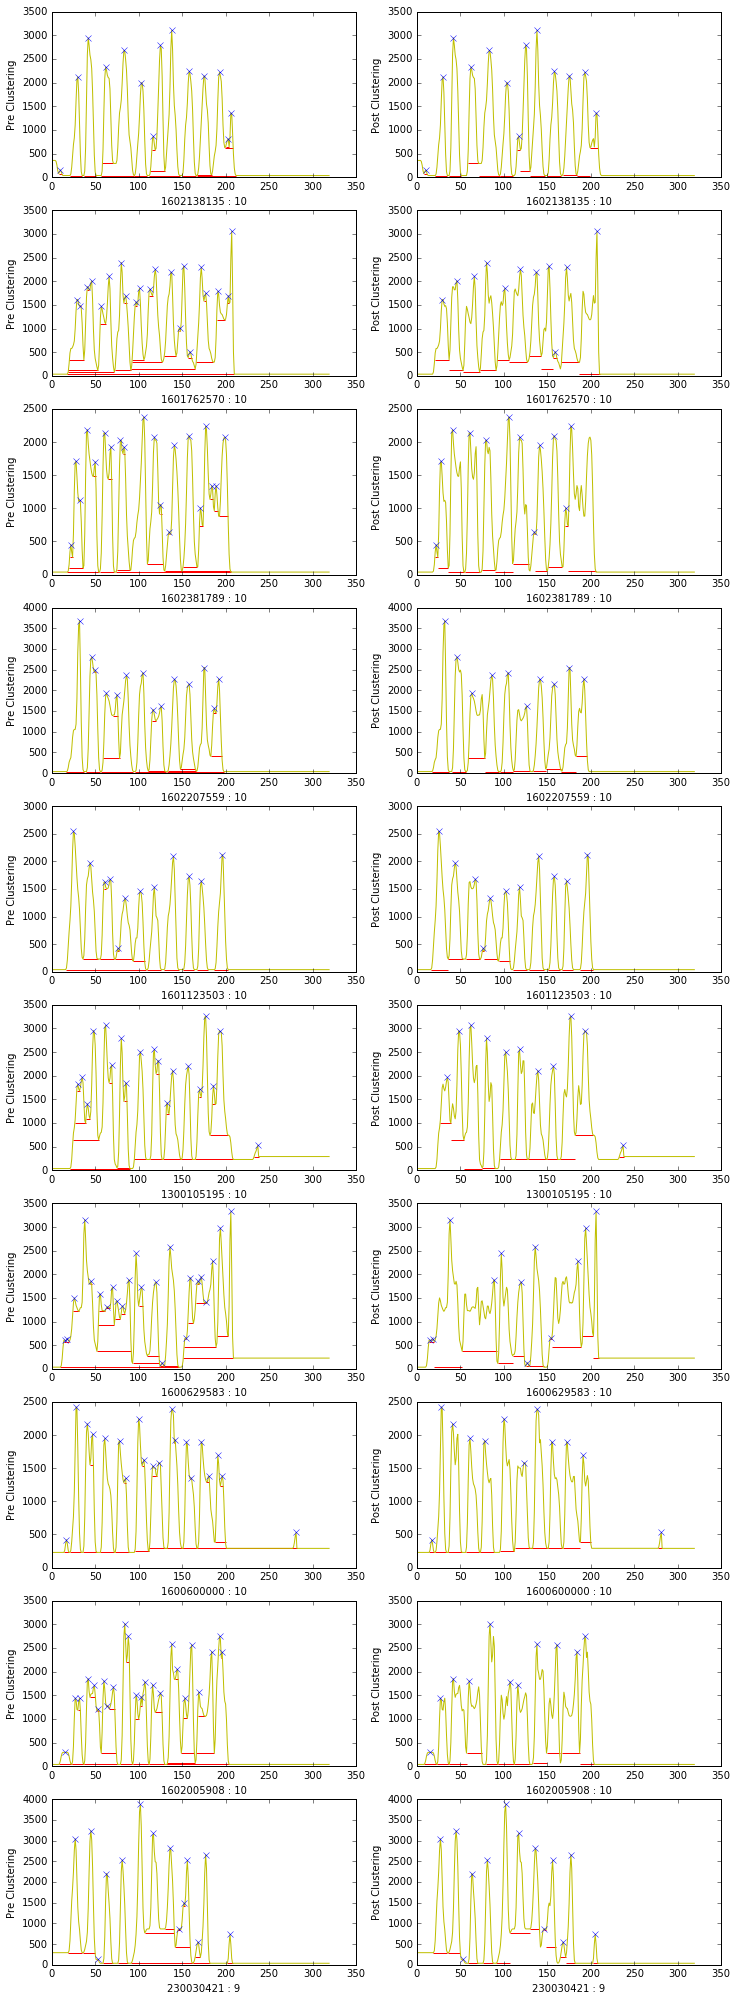

In [86]:
plot_projections(images_gray, labels, axis=0, threshold=0.65, plot_diff=True)

In [176]:
class Box(object):

    OVERLAP_X_EXTEND = 0 # pixels to virtually extend width to consider overlap
    
    def __init__(self, box):
        if type(box) is Box:
            self.box = box.box
        else:
            self.box = box

    def __str__(self):
        return "Box(x:{}, y:{}, w:{}, h:{})".format(*self.box)

    def __repr__(self):
        return self.__str__()

    def __lt__(self, other):
        """for sorting and box comparisions, comparing by x coordinate"""
        return self.box[0] < Box.get_box_obj(other).box[0]

    def __add__(self, other):
        """other can be instance of MergedBox/Box or list of box coordinates
        Note: destroys constituent boxes!
        """
        return self.merge(Box.get_box_obj(other))

    def __getitem__(self, key):
        return self.box[key]
    
    @staticmethod
    def merge_boxes(box1, box2):
        """merge boxes by taking max/min bounds to encompass largest area"""
        x1, y1, w1, h1 = box1
        xe1 = x1+w1
        ye1 = y1+h1
        x2, y2, w2, h2 = box2
        xe2 = x2+w2
        ye2 = y2+h2
        xn, yn, xen, yen = min(x1, x2), min(y1, y2), max(xe1, xe2), max(ye1, ye2)
        return xn, yn, xen-xn, yen-yn

    def merge(self, b_obj):
        # Note: destroys constituent boxes!
        # TODO: which .box? parent vs child
        return Box(Box.merge_boxes(self.box, b_obj.box))

    def diff(self, b_obj):
        # Note: destroys constituent boxes!
        # TODO: implement
        pass

    def area(self):
        return self.box[-1] * self.box[-2]
    
    @staticmethod
    def overlap_calc(b1, b2, thresh=True):
        """horizontal overlap, negative implies there is distance between boxes"""
        
        if (b1[0] < b2[0]):
            prev = b1
            nx = b2
        else:
            prev = b2
            nx = b1
        x1, y1, w1, h1 = prev
        x2, y2, w2, h2 = nx    
        res = x1 + w1 + (Box.OVERLAP_X_EXTEND if thresh else 0) - x2
        # if x2 < x1:
        #     # implies b2 is behind b1
        #     return -res
        return res
    
    @staticmethod
    def get_box_obj(b_obj):
        # Note: implicit conversion of MergedBox instance to Box by taking superbox
        if type(b_obj) is MergedBox:
            box = b_obj.box
        elif type(b_obj) is Box:
            box = b_obj
        else:
            # assuming b_obj is a tuple of box coordinates
            box = Box(b_obj)
        return box

    def overlap(self, b_obj, thresh=True):
        """overlap between box objects"""
        b1 = self.box
        b2 = Box.get_box_obj(b_obj).box
        return Box.overlap_calc(b1, b2, thresh)


class MergedBox(object):
    """MergedBox class to facilitate merging and holding multiple bounding box coordinates
    
    heirarchial structure: may hold multiple Box/MergedBox objects
    
    class design has been focused on seamless interoperability beween Box and MergedBox 
        instances in terms of add/merge, area and overlap computations
    """
    
    
    OVERLAP_X_THRESH = 0.5 # fraction of width overlap required to consider merging
    
    def __str__(self):
        return "MergedBox(x:{}, y:{}, w:{}, h:{})".format(*self.box.box)

    def __repr__(self):
        return self.__str__()
    
    def __lt__(self, other):
        """for sorting and box comparisions, comparing by x coordinate"""
        return self.box < other.box

    # def __getitem__(self, key):
    #     return self.boxes[key]

    # def __iter__(self):
    #     return self.boxes

    @property
    def box(self):
        # optimized via caching results, check correctness, add tests
        if self.cached:
            return self._res
        
        self._res = self.internal_merge()
        self.cached = True
        return self._res
    
    @box.setter
    def box(self, boxes):
        # boxes has to be list of objects which may be instances of Box/MergedBox
        self.cached = False
        self.boxes = boxes
        
    def __init__(self, boxes=[]):
        """boxes can be MergedBox/Box instance, list of Box/MergedBox instances, list of tuples of box coordinates, or single tuple of box coordinates"""
        # TODO: box label encapsulation, update in init args, add, sub
        # TODO: add support to hold peaks
        
        if type(boxes) is MergedBox:
            boxes = boxes.boxes
        elif type(boxes) is Box:
            boxes = [boxes, ]
        elif boxes: 
            if ((type(boxes[0]) is not tuple) and (type(boxes[0]) is not list)):
                # if boxes is non empty and first element of boxes is non iterable, implies: boxes is single
                # tuple of coordinates or boxes is list of Box/MergedBox objects            
                if type(boxes[0]) not in [MergedBox, Box]:
                    # implies boxes is single list of coordinates
                    boxes = [Box(boxes), ]
            else:
                # implies boxes is a nested list of coordinates 
                boxes = list(map(Box, boxes))
        
            # deprecated.
            # raise TypeError("argument `boxes` has to be list of tuples of box coordinates")
        
        self.cached = False # marks if self.box is computed
        self.boxes = boxes 
    
    @staticmethod
    def get_box_list(b_obj):
        if type(b_obj) is MergedBox:
            boxes = b_obj.boxes
        elif type(b_obj) is Box:
            boxes = [b_obj, ]
        else:
            pass
            # deprecated.
            # assuming b_obj is a tuple of box coordinates
            # boxes = [Box(b_obj), ]
        return boxes

    @staticmethod
    def get_mbox_obj(b_obj):
        if type(b_obj) in MergedBox:
            box = b_obj
        elif type(b_obj) is Box:
            boxes = [b_obj, ]
        else:
            # assuming b_obj is a tuple of box coordinates
            boxes = [Box(b_obj), ]
        return boxes

    def __add__(self, b_obj):
        """b_obj can be instance of MergedBox/Box

        # TODO: modify add behaviour: 
        """
        # return MergedBox(self.boxes + MergedBox.get_box_list(b_obj))
        
        # self.boxes.append(b_obj)

        return MergedBox(self.boxes + [b_obj, ])

    
    def __sub__(self, b_obj):
        """b_obj can be instance of MergedBox/Box or list of box coordinates"""
        # assuming common box elements are same array objects
        
        # check if b_obj is in list and pop and return 
        # if b_obj in self.boxes:
        #     self.boxes.remove(b_obj)
        #     return self

        boxes = list(self.boxes)
        if b_obj in boxes:
            boxes.remove(b_obj)
            return MergedBox(boxes)

        return MergedBox(list(set(self.boxes).difference(MergedBox.get_box_list(b_obj))))

    def internal_merge(self):
        # TODO: optimize by batch max/min
        if not self.boxes:
            return Box([0, 0, 0, 0])
        cur = self.boxes[0]
        for i in range(1, len(self.boxes)):
            cur = cur.merge(self.boxes[i])
        return cur

    def merge(self, b_obj):
        # Note: destroys constituent boxes!
        # TODO: which .box? parent vs child
        return self + b_obj
    
    def varea(self):
        """virtual area -> of the superbox encompassing all constituent boxes, is an overestimation and may include noise"""
        return self.box.area()
    
    def area(self):
        """actual area of Box by adding constituent box areas"""
        return sum(map(lambda b: b.area(), self.boxes))
    
    def sort(self):
        # sort all internal boxes as per `x` start
        self.boxes.sort()
    
    def overlap(self, b_obj, thresh=True):
        """overlap between MergedBox objects
        simple horizontal overlap logic: upgrade to vertical overlap or 
            fragmented `true` overlap as MergedBox constitutents may be discontinous


        `b_obj` can be MergedBox/Box instance or coordinate list as Box.overlap takes care of this
        """
        return self.box.overlap(b_obj.box, thresh)
    
    def best_overlap(self, b1_obj, b2_obj, thresh=True):
        """useful func for merging box with adjacent boxes in sorted list"""
        if self.overlap(b1_obj, thresh) > self.overlap(b2_obj, thresh):
            return b1_obj
        return b2_obj
    
    def ioverlaps(self):
        """calculates array of overlaps between sorted internal boxes"""
        self.sort()
        overlaps = []
        if not self.boxes:
            return overlaps
        bp = self.boxes[0]
        for b in range(1, len(self.boxes)):
            overlaps.append(bp.overlap(self.boxes[b]))
            bp = self.boxes[b]
        return overlaps
    
    def bifurcate(self, discard=False):
        """divides the box into two boxes by sensible overlap heuristic (minimize overlap?)"""
        pass
    
    def area_thresh(self, area_thresh):
        """applies area threshold on itself and returns Bool
            # TODO: figure out whether to do on superbox or true area?
        """
        pass
    
    def can_merge(self, b_obj):
        """returns whether merge possible with b_obj after applying overlap threshold
        
        # TODO: add param threshold fraction / absolute
        """
        overlap = self.overlap(b_obj)
        # if overlap > width threshold of current box or candidate box: perform merge
        if (overlap >= self.box[2] * MergedBox.OVERLAP_X_THRESH) or (overlap >= b_obj.box[2] * MergedBox.OVERLAP_X_THRESH):
            return True
        return False
    
    def peaks(self):
        pass
    
    def box_encloses(self, x):
        pass

    def distance(self, other):
        """opposite of overlap: convenience function"""
        return -self.overlap(other)

In [119]:
b = MergedBox()

In [163]:
"""
# TODO: check box filter post merging, prev boxes don't need to be nullified?
        optimize for identical boxes: same tuple by object ID
"""


# Logic
# overlap merge
# area filter merge target: ignore or merge (proximity/overlap threshold before merge/ignore)
#     merged noise: separate by distance
# keep top `n` by area?




def merge_routine(bbs, merge_func, passes=2):
    # one way adjacency? as i starts from `0`, already considered `prev` at i > 0?
    # fragmented box best overlap? components instead of super? for true overlap?
    # recursive merge in adjacency window? agglomerative heirachial clustering?
    # collapsing array?
    # retaining heirarchial structure via embedding Box within Box or subclassing Box
    for _ in range(passes):
        bbs.sort()
        # sorting by x coordinate
        for i, b in enumerate(bbs):
            # TODO: merge loops
            merge_func(bbs, i, b)
        bbs = list(filter(lambda x: x, bbs))
    bbs.sort()
    return bbs

def get_merge_func(adjacency_window_size=1, predecessor_only=False, thresh_func=lambda x: True):
    def merge_candidate(bbs, i, b, adjacency_window_size=1):
        lims = (i-adjacency_window_size, i+(adjacency_window_size if not predecessor_only else 0)+1)
        adjacents = [(j, bbs[j]) for j in range(*lims) \
                     if j != i and j>=0 and j<len(bbs) and bbs[j] is not None]

        # for j, b2 in enumerate(adjacents):
        #     pass
        
        if adjacents:
            # best overlap in adjacents
            j, a = max(adjacents, key=lambda x: b.overlap(x[1]))
            
            # TODO: comment architecture philosophy
            if thresh_func(b, a):
            #if b.can_merge(a):
                # pushing merged box in maximum index btw i, j so it may be referenced in subsequent adjacency iterations
                bbs[max(i, j)] = b + a
                bbs[min(i, j)] = None
    return merge_candidate


In [174]:
b = MergedBox([[1, 1, 2, 2], [4, 4, 1, 1], ])      
print(b.ioverlaps())

bbs = [b, ]

def box_merge_routines(bbs):
    ###
    # Box merge routines: overlap threshold
    ###
    
    thresh_func = lambda x, y: x.can_merge(y)
    merge_function = get_merge_func(thresh_func=thresh_func)
    bbs = merge_routine(bbs, merge_func=merge_function, passes=1)
    
    ###
    # Box merge routines: area Gauss filter, overlap threshold and best adjacent merge
    ###
    
    areas = list(map(lambda x: x.varea(), bbs))
    mean_a = np.mean(areas)
    std_a = np.std(areas)
    thresh_a = mean_a - std_a

    thresh_func = lambda x, y: (x.area() <= thresh_a or y.area() <= thresh_a) and (x.overlap(y) > -2)
    merge_function = get_merge_func(thresh_func=thresh_func)
    bbs = merge_routine(bbs, merge_func=merge_function, passes=1)


    thresh_func = lambda x, _: x.area() <= thresh_a - std_a*0.75
    merge_function = get_merge_func(thresh_func=thresh_func)
    bbs = merge_routine(bbs, merge_func=merge_function, passes=1)

    return bbs
    
box_merge_routines(bbs)

[-1]


[MergedBox(x:1, y:1, w:4, h:4)]

i: 0
height:  2145.0
i: 1
height:  1925.0625
i: 2
height:  1807.21428571
i: 3
height:  2198.5


/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


i: 4
height:  1638.75
threshold:  46.2255580469 138.769230769 92.5436727224 4
threshold:  46.2255580469 138.769230769 92.5436727224 4
threshold:  46.2255580469 138.769230769 92.5436727224 16
threshold:  46.2255580469 138.769230769 92.5436727224 16
threshold:  46.2255580469 138.769230769 92.5436727224 42
i: 5
height:  2451.46153846
mean widht:  11.6444458728 , mean height:  2451.46153846
cand:  (192, 0.0, 183.0, 183.0) , height:  2996
mean widht:  11.6444458728 , mean height:  2451.46153846
cand:  (73, 2.0, 72.0, 74.0) , height:  128
mean widht:  11.6444458728 , mean height:  2451.46153846
cand:  (41, 4.5756207674943568, 39.424379232505643, 44.0) , height:  1466
mean widht:  11.6444458728 , mean height:  2451.46153846
cand:  (48, 9.0, 44.0, 53.0) , height:  3059
mean widht:  11.6444458728 , mean height:  2451.46153846
cand:  (157, 11.0, 150.0, 161.0) , height:  2231
mean widht:  11.6444458728 , mean height:  2451.46153846
cand:  (35, 12.9765625, 26.0234375, 39.0) , height:  1975
mean wi

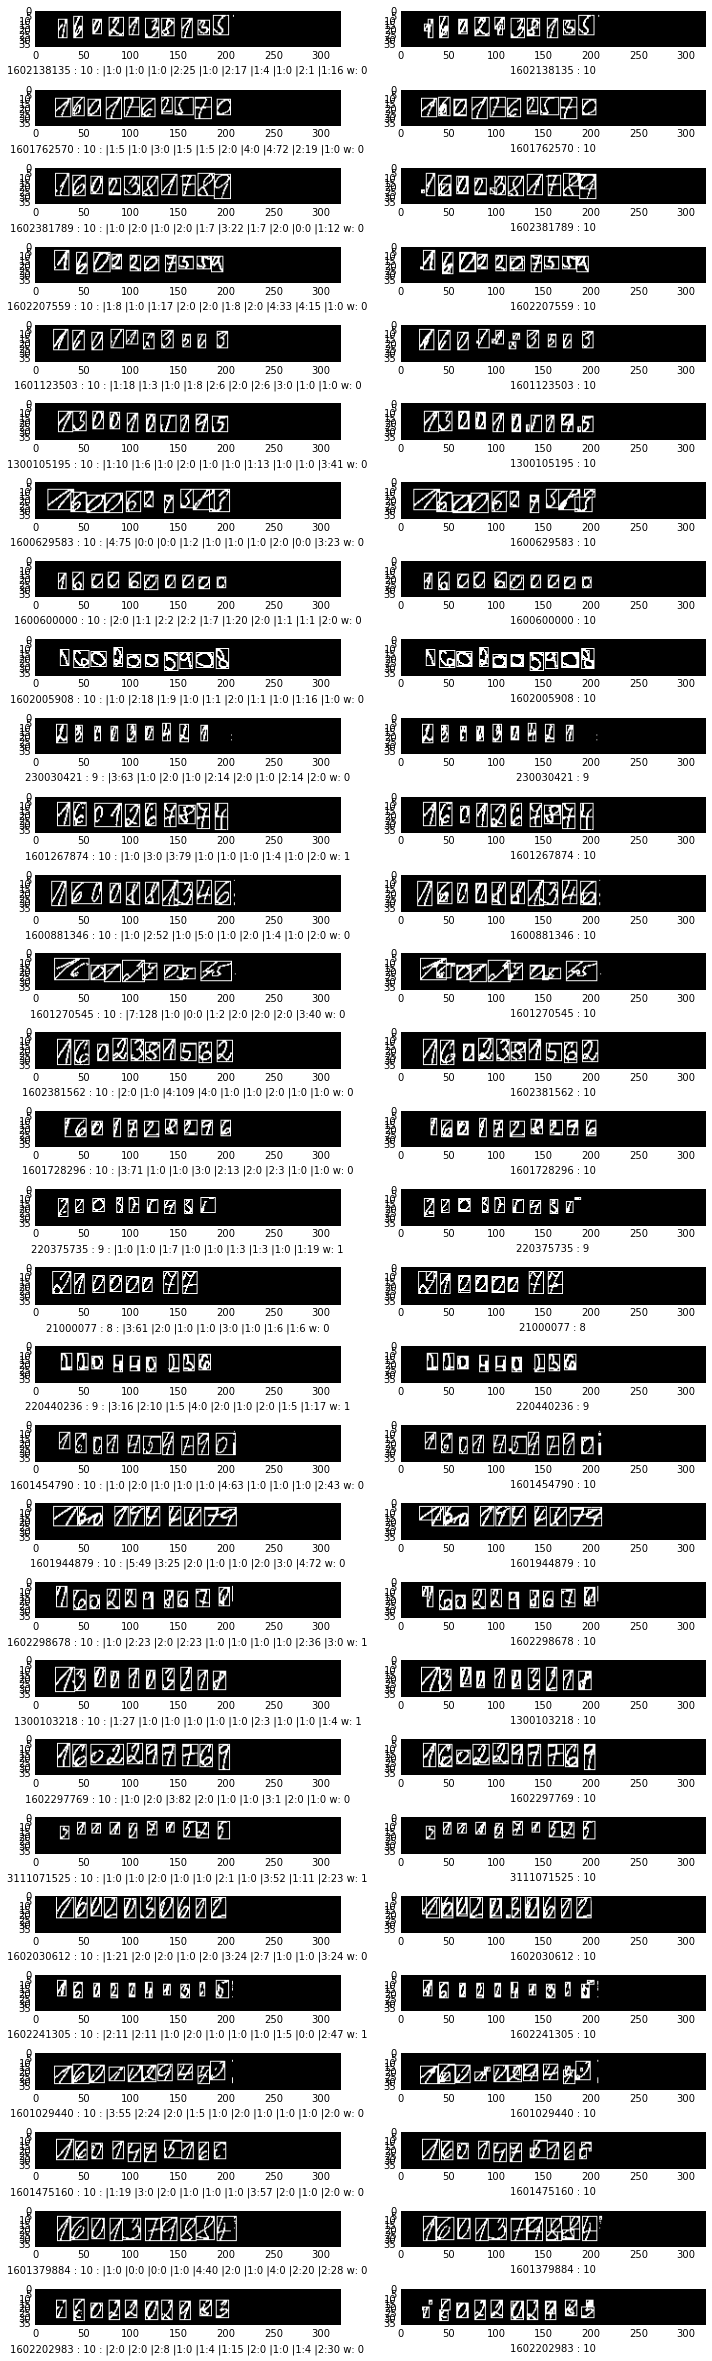

In [175]:
ALPHA = True
AREA_FILTERS = True
AREA_FILTERS_2 = True

# TODO: pipeline image transformations and remove repetetive code
bb_heights = []
bb_widths = []
for i, axes in gen_subplot_group(30*2, size=1.0, yield_group=2):
    print("i: {}".format(i))
    ax1, ax2 = axes
    img_g = images_gray[i]
    ret, thresh = cv2.threshold(img_g, 200, 255,cv2.THRESH_BINARY_INV)
    # Gaussian filter will remove noise, kernel size has been optimized by trial and error
    # the x projection has much higher noise fluctuations and is more affected
    # by kernel choices
    blur_img = cv2.GaussianBlur(thresh, (3, 3), 0)
    
    ###
    # y axis projection
    ###
    
    project = np.sum(blur_img, axis=1)
    peaks, peak_widths_l, peak_base_heights, starts, ends = process_projection_peaks(project)
    
    mx_w_ind = np.argmax(peak_widths_l)
    st, en = starts[mx_w_ind], ends[mx_w_ind]
    
    masked = np.copy(thresh)
    masked[:st, :] = 0
    masked[en:, :] = 0
    
    ###
    # x axis projection
    ###
    
    project = np.sum(blur_img, axis=0)
    peaks, peak_widths_l, peak_base_heights, starts, ends = process_projection_peaks(project, threshold=0.65)
    mean_width = np.mean(peak_widths_l)
    mean_height = np.mean(list(map(lambda x: project[x], peaks)))
    print("height: ", mean_height)
    peak_stats = list(zip(peaks, peak_widths_l, starts, ends))
    peak_stats.sort(key=lambda x: x[2] * 10000 + x[3])
    # high peak candidates are more important to be removed
    # apply peak threshold
    rem_cand = peak_stats[:5] + peak_stats[-5:] # only take edge candidates for removal
    rem_cand.sort(key=lambda x: x[1]) # sort candidates by width candidates
#     rem_cand = rem_cand[:2] # take first two least width candidates
#     print("shape", img_g.shape[1] / 2)
#     print("mean width: ", mean_width)
    for cand in rem_cand:
        if labels[i] == "1300105195":
            print("mean widht: ", mean_width, ", mean height: ", mean_height)
            print("cand: ", cand, ", height: ", project[cand[0]])
        # if candidate width is less than half of mean_width
        # remove candidate from image
        # TODO: hyperparameters
        if 0 <cand[1] < 0.6 * mean_width and mean_height * 1.5 < project[cand[0]]:
            # if candidate is on left of image
            if cand[-1] < (img_g.shape[1] / 2):
                masked[:, cand[-2]:cand[-1]] = 0
            # else candidate is on right of image
            else: 
                # TODO: merge filters
                masked[:, cand[-2]:cand[-1]] = 0
    
    ###
    # Bounding box detection routines
    ###
    
    clone = masked.copy()
    clone2 = masked.copy()
    clone_masked = masked.copy()
    im2, contours, hierarchy = cv2.findContours(masked, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    b_widths = []
    b_heights = []
    boxes = []
    for (k, c) in enumerate(contours):
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        b_widths.append(w)
        b_heights.append(h)
        # only accept the contour region as a grouping of characters if
        # the ROI is sufficiently large
        if w >= 2 and h >= 2:
            boxes.append((x, y, w, h))
            cv2.rectangle(clone, (x,y), (x+w, y+h), (255,0,0), 1)
    
    # ALPHA TEST
    bbs = list(map(MergedBox, boxes))
    bbs = box_merge_routines(bbs)
#     bbs = list(map(lambda x: x.box.box, box_merge_routines(bbs)))
    # ALPHA TEST ENDS
    
    box_filtered = clone2
    
    
    ###
    # Drawing Box routine
    ###      
    
    for box in bbs:
        (x, y, w, h) = box
        cv2.rectangle(box_filtered, (x,y), (x+w, y+h), (255, 0, 0), 1)
               
    
    ###
    # Box SPLIT routines: canny peaks counts/importance, box width Gauss filter
    ###
    
    # test: detect multiple peaks in conjoined images:
    blurred_clone = cv2.GaussianBlur(clone_masked, (3,3), 0)
    canny_res = cv2.Canny(blurred_clone, 300, 900)
    project = np.sum(canny_res, axis=0) # clone_masked
    peaks, peak_widths_l, peak_base_heights, starts, ends = process_projection_peaks(project, threshold=0.75)
    # TODO: machine learning n_peaks -> dual digits
    peaks = sorted(peaks)
    peaks_in_boxes = []
    wasted_peaks = []
    p_i = 0
    
    bbs.sort()
    boxes = list(map(lambda x: x.box.box, bbs))
#     boxes.sort(key=lambda x: x[0])
    
    b_widths = list(map(lambda x: x[2], boxes))
#     b_heigh = list(map(lambda x: x[3], boxes))
    w_mean, w_std = np.mean(b_widths), np.std(b_widths)
    for box in boxes:
        peaks_in_boxes.append([])
        (x, y, w, h) = box
        w_z_score = (w-w_mean) / w_std
        if w_z_score < 0:
            w_z_score = 0
        while p_i < len(peaks) and peaks[p_i] <= x+w:
            # check apply higher threshold? use higher gaussian kernel?
            peak_imp_score = w_z_score*10#peak_widths_l[p_i] * (project[peaks[p_i]] - peak_base_heights[p_i])
            if x <= peaks[p_i] <= x+w:
                peaks_in_boxes[-1].append((peaks[p_i], peak_imp_score))
            else:
                wasted_peaks.append(peaks[p_i])
            p_i += 1
    
    while p_i < len(peaks):
        wasted_peaks.append(peaks[p_i])
        p_i += 1
    
    
    ###
    # Visualizations
    ###
    
    
    peak_counts = [len(x) for x in peaks_in_boxes]
    peak_imp = [(int(sum(list(zip(*x))[1])/1) if x else 0) for x in peaks_in_boxes]
    peak_counts = " ".join(map(lambda x, y: "|{}:{}".format(x, y), peak_counts, peak_imp))
    
    bb_widths.append(b_widths)
    bb_heights.append(b_heights)
    
#     ax1.imshow(clone, cmap="gray")
#     ax1.set_xlabel(labels[i] + " : {}".format(len(labels[i])))
#     ax1.set_ylabel("boxes ori")
    
    ax1.imshow(box_filtered, cmap="gray")
    ax1.set_xlabel(labels[i] + " : {}".format(len(labels[i])) + " : " + peak_counts + " w: {}".format(len(wasted_peaks)))
    
    canny_res = cv2.Canny(clone_masked, 300, 900)
    ax2.imshow(clone, cmap="gray") # clone, thresh
    ax2.set_xlabel(labels[i] + " : {}".format(len(labels[i])))
#     ax2.set_ylabel("box filtered")
    # any box with 30% or higher overlap in vertical is merged
    # merge smaller below threshold with closest larger
    
    
    

In [99]:
bres = [[1, 2, 3, 4]]
print(list(map(str, list(map(MergedBox, bres)))))

['Box(x:1, y:2, w:3, h:4)']


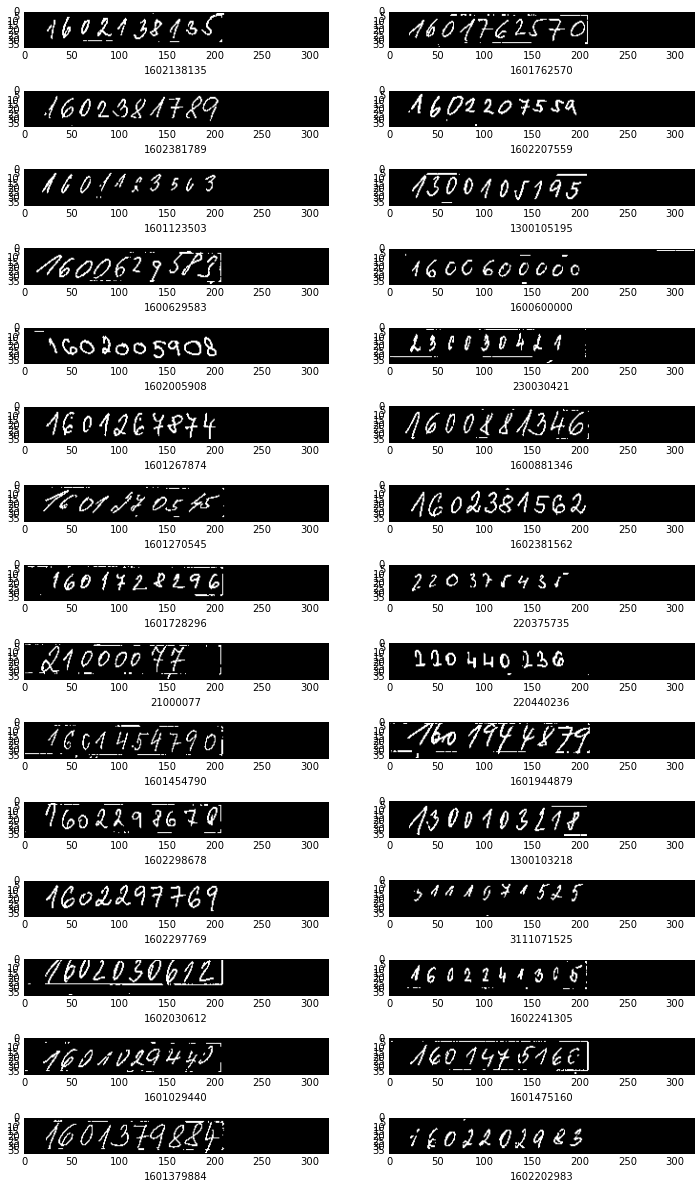

In [128]:
# TODO: pipeline image transformations and remove repetetive code
for i, axes in gen_subplot_group(30):
    ax = axes[0]
    img_g = images_gray[i]
    ret, thresh = cv2.threshold(img_g, 200, 255,cv2.THRESH_BINARY_INV)
#     blur_img = cv2.GaussianBlur(thresh, (3, 3), 0)
    plt.imshow(thresh, cmap="gray")
    ax.set_xlabel(labels[i])

b height mean:  11.9 , b width mean:  11.8
b height mean:  12.8888888889 , b width mean:  14.8
b height mean:  15.2222222222 , b width mean:  14.6
b height mean:  13.5 , b width mean:  13.1
b height mean:  11.375 , b width mean:  11.3
b height mean:  14.1666666667 , b width mean:  12.2
b height mean:  11.8571428571 , b width mean:  16.8
b height mean:  11.6428571429 , b width mean:  10.8
b height mean:  12.5263157895 , b width mean:  13.5
b height mean:  11.1176470588 , b width mean:  8.0
b height mean:  15.5882352941 , b width mean:  15.0
b height mean:  13.7272727273 , b width mean:  16.7777777778
b height mean:  8.96 , b width mean:  21.125
b height mean:  13.8947368421 , b width mean:  16.1111111111
b height mean:  11.1578947368 , b width mean:  12.2222222222
b height mean:  10.3571428571 , b width mean:  10.1111111111
b height mean:  14.5333333333 , b width mean:  13.25
b height mean:  12.8571428571 , b width mean:  10.5555555556
b height mean:  12.7222222222 , b width mean:  12.5

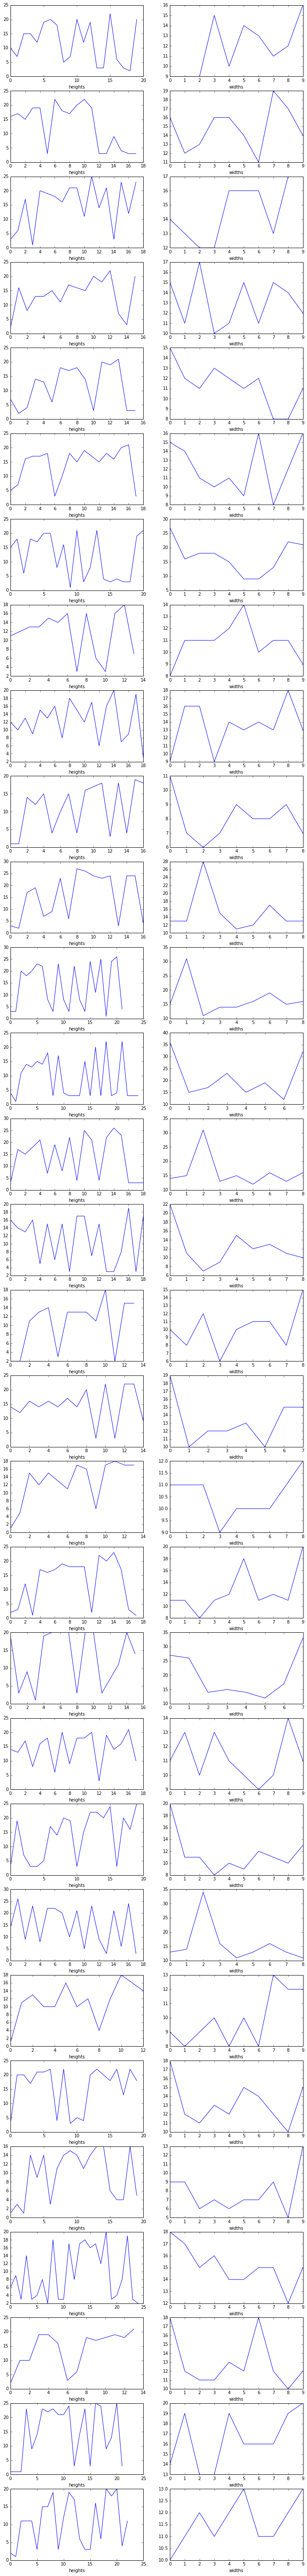

In [92]:
for (b_heights, b_widths), (i, axes) in zip(zip(bb_heights, bb_widths), gen_subplot_group(len(bb_heights)*2, size=2.5, yield_group=2)):
    print("b height mean: ", np.mean(b_heights), ", b width mean: ", np.mean(b_widths))
    axes[0].plot(b_heights)
    axes[0].set_xlabel("heights")
    axes[1].plot(b_widths)
    axes[1].set_xlabel("widths")

In [25]:




b = Box([list(range(4)), ])
b += Box([list(range(2, 6)), ])
b.box

(0, 1, 6, 7)

In [22]:
print([list(range(4)), ])

[[0, 1, 2, 3]]


TypeError: 'int' object is not iterable